# House Prices: Advanced Regression Techniques

**Author:** Jhosimar George Arias Figueroa

## Introduction

This notebook is intended to be a guide for education on the Kaggle problem: **House Prices** (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). Here we will see data preparation, basic feature engineering and application of the most basic linear regression models.

## Load Data

First let's import some packages that will be used throughout this notebook

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

Let's import data using the pandas package (https://pandas.pydata.org/). The Pandas package helps us work with our datasets. We start by reading the training and test datasets into DataFrames.

In [2]:
# dataset is obtained from kaggle directly
# you can change the directory to your own dataset
train = pd.read_csv('/kaggle/home_price/dataset/train.csv')
test = pd.read_csv('/kaggle/home_price/dataset/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



The Id column will not be required in this notebook. It will be useful when preparing the submission data into the kagggle plataform to evaluate the model. We will drop this column from the training and test datasets.


In [3]:
# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the  'Id' column as it's redundant for modeling
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print(train.shape)
print(test.shape)
train.head()

(1460, 80)
(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Preparation

### Missing values

A missing value is an entry in a column that has no assigned value. A missing value may be the **result of an error during the production of the dataset**. This could be a human error, or machinery error depending on where the data comes from. 

Some algorithms do not like missing values. Some are capable of handling them, but others are not. Therefore since we are using a variety of algorithms, it's best to treat them in an appropriate way.

**If you have missing values, you have two options**:
- Delete the entire row
- Fill the missing entry with an imputed value

In this notebook we will fill the missing entries with values according to the description of the dataset.

In [4]:
# First of all, save the length of the training and test data for use later
num_train = train.shape[0]
num_test = test.shape[0]

# Also save the target value, as we will remove this
y_train = train.SalePrice.values

# concatenate training and test data into all_data
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data shape: {}".format(all_data.shape))

all_data shape: (2919, 79)


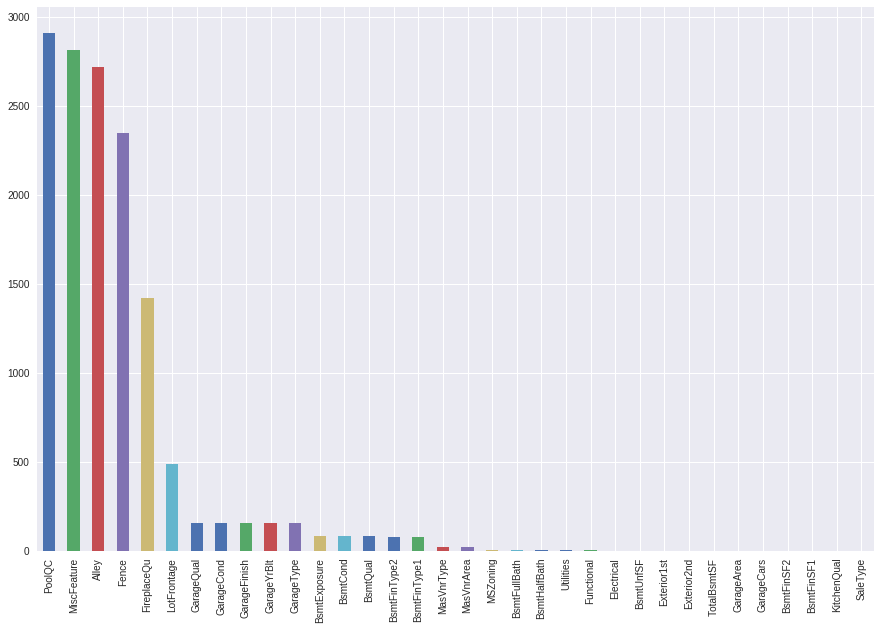

In [5]:
# aggregate all null values 
all_data_na = all_data.isnull().sum()

# get rid of all the values with 0 missing values
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.subplots(figsize =(15, 10))
all_data_na.plot(kind='bar');

**PoolQC : **  Pool quality

* Ex - Excellent
* Gd - Good
* TA - Average/Typical
* Fa - Fair
* NA - No Pool
 
Data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 



In [6]:
all_data['PoolQC'][all_data['PoolQC'].notnull()]

197     Ex
810     Fa
1170    Gd
1182    Ex
1298    Gd
1386    Fa
1423    Gd
1974    Ex
2573    Ex
2710    Gd
Name: PoolQC, dtype: object

In [0]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [8]:
all_data['PoolQC'].head()

0    None
1    None
2    None
3    None
4    None
Name: PoolQC, dtype: object

**MiscFeature:** Miscellaneous feature not covered in other categories

* Elev - Elevator
* Gar2 - 2nd Garage (if not described in garage section)
* Othr - Other
* Shed - Shed (over 100 SF)
* TenC - Tennis Court
* NA - None

Data description says NA means "no misc feature"

In [0]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

**Alley:** Type of alley access to property

* Grvl - Gravel
* Pave - Paved
* NA - No alley access

**Fence:** Fence quality

* GdPrv - Good Privacy
* MnPrv - Minimum Privacy
* GdWo - Good Wood
* MnWw - Minimum Wood/Wire
* NA - No Fence

**FireplaceQu:** Fireplace quality

* Ex - Excellent - Exceptional Masonry Fireplace
* Gd - Good - Masonry Fireplace in main level
* TA - Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
* Fa - Fair - Prefabricated Fireplace in basement
* Po - Poor - Ben Franklin Stove
* NA - No Fireplace

**GarageType:** Garage location

* 2Types - More than one type of garage
* Attchd - Attached to home
* Basment - Basement Garage
* BuiltIn - Built-In (Garage part of house - typically has room above garage)
* CarPort - Car Port
* Detchd - Detached from home
* NA - No Garage

**GarageFinish:** Interior finish of the garage

* Fin - Finished
* RFn - Rough Finished  
* Unf - Unfinished
* NA - No Garage

**GarageQual:** Garage quality

* Ex - Excellent
* Gd - Good
* TA - Typical/Average
* Fa - Fair
* Po - Poor
* NA - No Garage

**GarageCond:** Garage condition

* Ex - Excellent
* Gd - Good
* TA - Typical/Average
* Fa - Fair
* Po - Poor
* NA - No Garage

**BsmtQual:** Evaluates the height of the basement

* Ex - Excellent (100+ inches) 
* Gd - Good (90-99 inches)
* TA - Typical (80-89 inches)
* Fa - Fair (70-79 inches)
* Po - Poor (&lt;70 inches
* NA - No Basement

**BsmtCond:** Evaluates the general condition of the basement

* Ex - Excellent
* Gd - Good
* TA - Typical - slight dampness allowed
* Fa - Fair - dampness or some cracking or settling
* Po - Poor - Severe cracking, settling, or wetness
* NA - No Basement

**BsmtExposure:** Refers to walkout or garden level walls

* Gd - Good Exposure
* Av - Average Exposure (split levels or foyers typically score average or above)  
* Mn - Mimimum Exposure
* No - No Exposure
* NA - No Basement

**BsmtFinType1:** Rating of basement finished area

* GLQ - Good Living Quarters
* ALQ - Average Living Quarters
* BLQ - Below Average Living Quarters 
* Rec - Average Rec Room
* LwQ - Low Quality
* Unf - Unfinshed
* NA - No Basement

**BsmtFinType2:** Rating of basement finished area (if multiple types)

* GLQ - Good Living Quarters
* ALQ - Average Living Quarters
* BLQ - Below Average Living Quarters 
* Rec - Average Rec Room
* LwQ - Low Quality
* Unf - Unfinshed
* NA - No Basement

**MasVnrType:** Masonry veneer type

* BrkCmn - Brick Common
* BrkFace -  Brick Face
* CBlock - Cinder Block
* None - None
* Stone - Stone


In [0]:
# Using data description, fill these missing values with "None"
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
           "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2", "MasVnrType"):
    all_data[col] = all_data[col].fillna("None")

**LotFrontage :** Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the **median** LotFrontage of the neighborhood.

In [11]:
# example of groupby and mean w.r.t. lost frontage
all_data.groupby("Neighborhood")["LotFrontage"].median()

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    65.0
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    89.0
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

In [0]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

**GarageYrBlt:** Year garage was built

**GarageCars:** Size of garage in car capacity

**GarageArea:** Size of garage in square feet

**BsmtFinSF1:** Type 1 finished square feet

**BsmtFinSF2:** Type 2 finished square feet

**BsmtUnfSF:** Unfinished square feet of basement area

**TotalBsmtSF:** Total square feet of basement area

**MasVnrArea:** Masonry veneer area in square feet

**BsmtFullBath:** Basement full bathrooms

**BsmtHalfBath:** Basement half bathrooms

In [0]:
# Using data description, fill these missing values with 0 
for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)

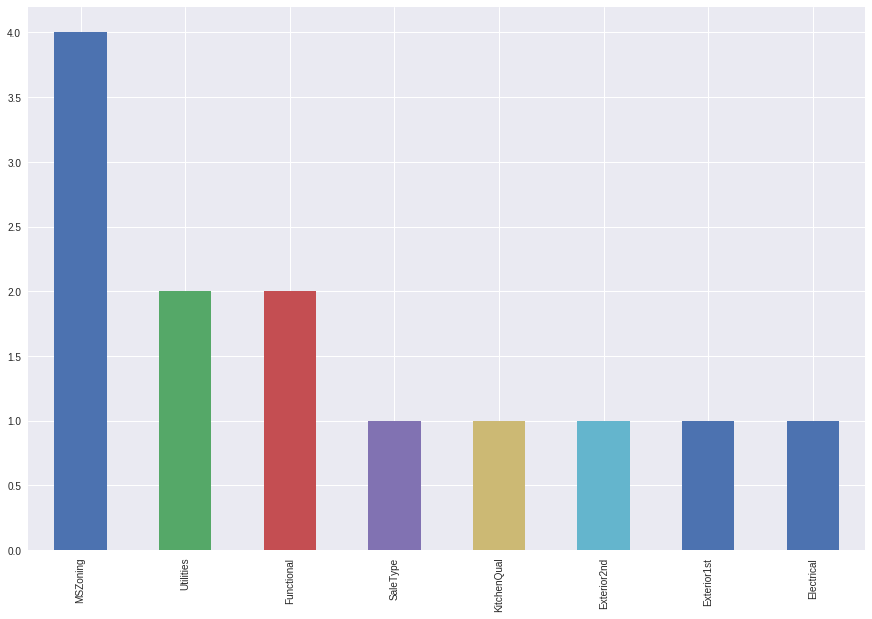

In [14]:
# aggregate all null values 
all_data_na = all_data.isnull().sum()

# get rid of all the values with 0 missing values
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.subplots(figsize =(15, 10))
all_data_na.plot(kind='bar');

**MSZoning:** Identifies the general zoning classification of the sale.

* A - Agriculture
* C - Commercial
* FV - Floating Village Residential
* I - Industrial
* RH - Residential High Density
* RL - Residential Low Density
* RP - Residential Low Density Park 
* RM - Residential Medium Density


**Utilities:** Type of utilities available

* AllPub - All public Utilities (E,G,W,& S)  
* NoSewr - Electricity, Gas, and Water (Septic Tank)
* NoSeWa - Electricity and Gas Only
* ELO - Electricity only  

**Functional:** Home functionality (Assume typical unless deductions are warranted)

* Typ - Typical Functionality
* Min1 - Minor Deductions 1
* Min2 - Minor Deductions 2
* Mod - Moderate Deductions
* Maj1 - Major Deductions 1
* Maj2 - Major Deductions 2
* Sev - Severely Damaged
* Sal - Salvage only


**SaleType:** Type of sale

* WD - Warranty Deed - Conventional
* CWD - Warranty Deed - Cash
* VWD - Warranty Deed - VA Loan
* New - Home just constructed and sold
* COD - Court Officer Deed/Estate
* Con - Contract 15% Down payment regular terms
* ConLw - Contract Low Down payment and low interest
* ConLI - Contract Low Interest
* ConLD - Contract Low Down
* Oth - Other

**KitchenQual:** Kitchen quality

* Ex - Excellent
* Gd - Good
* TA - Typical/Average
* Fa - Fair
* Po - Poor

**Exterior1st:** Exterior covering on house

* AsbShng - Asbestos Shingles
* AsphShn - Asphalt Shingles
* BrkComm - Brick Common
* BrkFace - Brick Face
* CBlock - Cinder Block
* CemntBd - Cement Board
* HdBoard - Hard Board
* ImStucc - Imitation Stucco
* MetalSd - Metal Siding
* Other - Other
* Plywood - Plywood
* PreCast - PreCast 
* Stone - Stone
* Stucco - Stucco
* VinylSd - Vinyl Siding
* Wd Sdng - Wood Siding
* WdShing - Wood Shingles

**Exterior2nd:** Exterior covering on house (if more than one material)

* AsbShng - Asbestos Shingles
* AsphShn - Asphalt Shingles
* BrkComm - Brick Common
* BrkFace - Brick Face
* CBlock - Cinder Block
* CemntBd - Cement Board
* HdBoard - Hard Board
* ImStucc - Imitation Stucco
* MetalSd - Metal Siding
* Other - Other
* Plywood - Plywood
* PreCast - PreCast
* Stone - Stone
* Stucco - Stucco
* VinylSd - Vinyl Siding
* Wd Sdng - Wood Siding
* WdShing - Wood Shingles

**Electrical:** Electrical system

* SBrkr - Standard Circuit Breakers & Romex
* FuseA - Fuse Box over 60 AMP and all Romex wiring (Average) 
* FuseF - 60 AMP Fuse Box and mostly Romex wiring (Fair)
* FuseP - 60 AMP Fuse Box and mostly knob & tube wiring (poor)
* Mix - Mixed

Fill these features with their mode, the most commonly occuring value. This is okay since there are a low number of missing values for these features

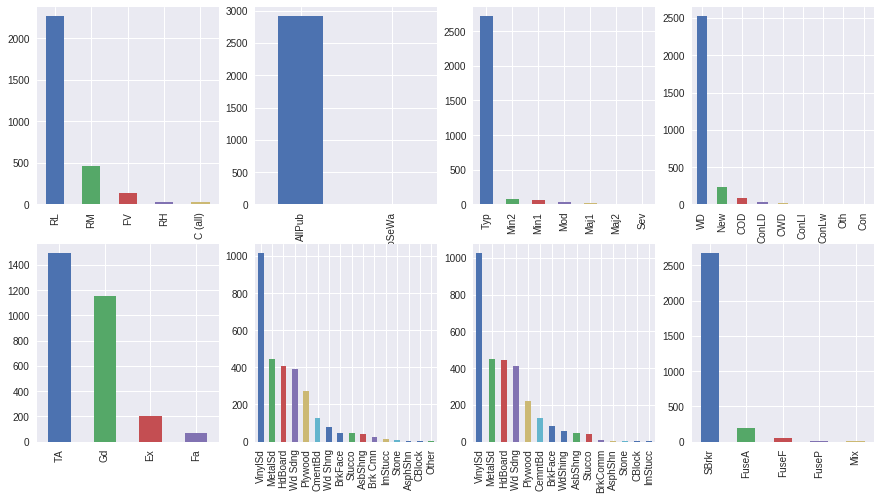

In [15]:
feature_columns = ["MSZoning", "Utilities", "Functional", "SaleType", "KitchenQual", "Exterior2nd", "Exterior1st", "Electrical"]

plt.subplots(figsize =(15, 8))
for i in range(0, len(feature_columns)):
  plt.subplot(2, 4, i+1)
  all_data[feature_columns[i]].value_counts().plot(kind='bar');

In [0]:
for col in feature_columns:
  all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

The categorical feature **Utilities** has an strange behaviour regarding the value count. Let's analize it.

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


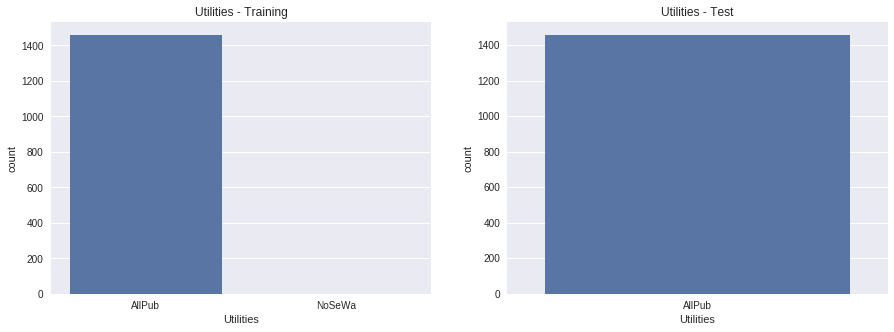

In [17]:
plt.subplots(figsize =(15, 5))

plt.subplot(1, 2, 1)
g = sns.countplot(x = "Utilities", data = train).set_title("Utilities - Training")

plt.subplot(1, 2, 2)
g = sns.countplot(x = "Utilities", data = test).set_title("Utilities - Test")

**Utilities :** For this categorical feature all records are "AllPub", except for one "NoSeWa" and 20 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [18]:
# From inspection, we can remove Utilities
all_data = all_data.drop(['Utilities'], axis=1)

all_data_na = all_data.isnull().sum()
print("Features with missing values: ", len(all_data_na.drop(all_data_na[all_data_na == 0].index)))

('Features with missing values: ', 0)


## Feature Engineering

### Convert numerical to categorical

**MSSubClass:** Identifies the type of dwelling involved in the sale.

* 20 - 1-STORY 1946 & NEWER ALL STYLES
* 30 - 1-STORY 1945 & OLDER
* 40 - 1-STORY W/FINISHED ATTIC ALL AGES
* 45 - 1-1/2 STORY - UNFINISHED ALL AGES
* 50 - 1-1/2 STORY FINISHED ALL AGES
* 60 - 2-STORY 1946 & NEWER
* 70 - 2-STORY 1945 & OLDER
* 75 - 2-1/2 STORY ALL AGES
* 80 - SPLIT OR MULTI-LEVEL
* 85 - SPLIT FOYER
* 90 - DUPLEX - ALL STYLES AND AGES
* 120 - 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
* 150 - 1-1/2 STORY PUD - ALL AGES
* 160 - 2-STORY PUD - 1946 & NEWER
* 180 - PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
* 190 - 2 FAMILY CONVERSION - ALL STYLES AND AGES

In [19]:
all_data['MSSubClass'].head()

0    60
1    20
2    60
3    70
4    60
Name: MSSubClass, dtype: int64

In [0]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

**MoSold:** Month Sold (MM)

**YrSold:** Year Sold (YYYY)

In [0]:
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### Save numeric and categorical feature column names

In [22]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
print ('Numeric Features: %d' % numeric_feats.shape[0])
  
categorical_feats = all_data.dtypes[all_data.dtypes == "object"].index
print ('Categorical Features: %d' % categorical_feats.shape[0])

Numeric Features: 33
Categorical Features: 45


### Discretize categorical attributes

Convert all categorical data to one-hot (dummy encoding)

In [23]:
all_data = pd.get_dummies(all_data, columns = categorical_feats)
print all_data.shape

(2919, 330)


In [24]:
all_data.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1159.581706,336.483727,2.602261,2.860226,441.272011,49.565262,0.429599,0.061322,560.579993,23.098321,...,0.081877,0.002398,0.865365,0.004111,0.995889,0.212059,0.237067,0.213087,0.221651,0.116136
std,392.362079,428.701456,25.188169,0.822693,455.606014,169.179104,0.524676,0.245608,439.590889,64.244246,...,0.274225,0.048920,0.341392,0.063996,0.063996,0.408836,0.425357,0.409559,0.415429,0.320442
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.000000,0.000000,0.000000,0.000000,467.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1387.500000,704.000000,0.000000,3.000000,733.000000,0.000000,1.000000,0.000000,805.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5095.000000,2065.000000,508.000000,8.000000,5644.000000,1526.000000,3.000000,2.000000,2336.000000,1012.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Skewed Data

#### Target Variable

- Unlike classification, **in regression we are predicting a continuous number**. Hence, the prediction could be any number along the real number line.
- Therefore, it is always useful to check the distribution of the target variable, and indeed all numeric variables, when building a regression model. Machine Learning algorithms work well with features that are **normally distributed**, a distribution that is symmetric and has a characteristic bell shape. If features are not normally distributed, you can transform them using clever statistical methods.
- First, let's check the target variable.

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


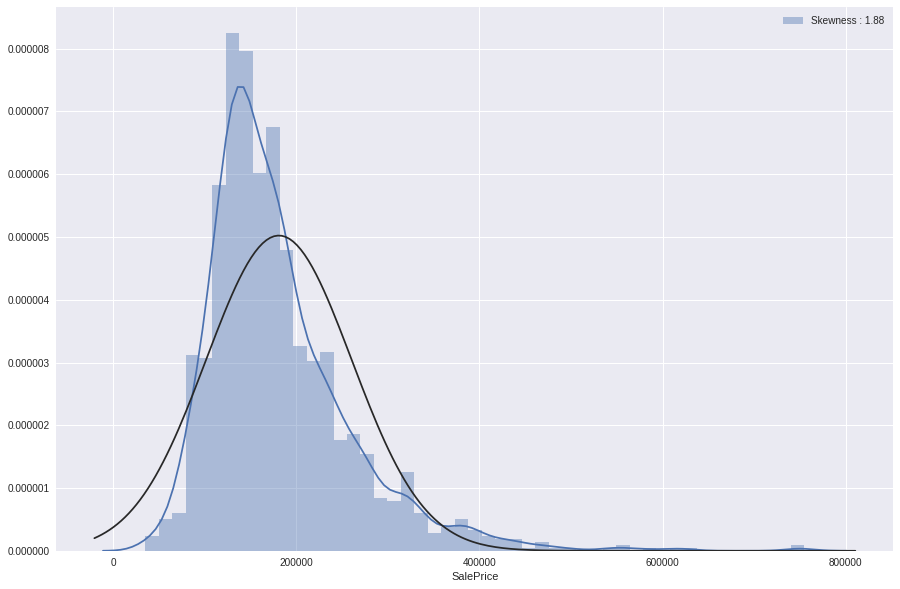

In [25]:
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=stats.norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

The distribution of the target variable is **positively skewed**, meaning that the mode is always less than the mean and median. 

- In order to transform this variable into a distribution that looks closer to the black line shown above, we can use the **numpy function log1p** which applies log(1+x) to all elements within the feature.

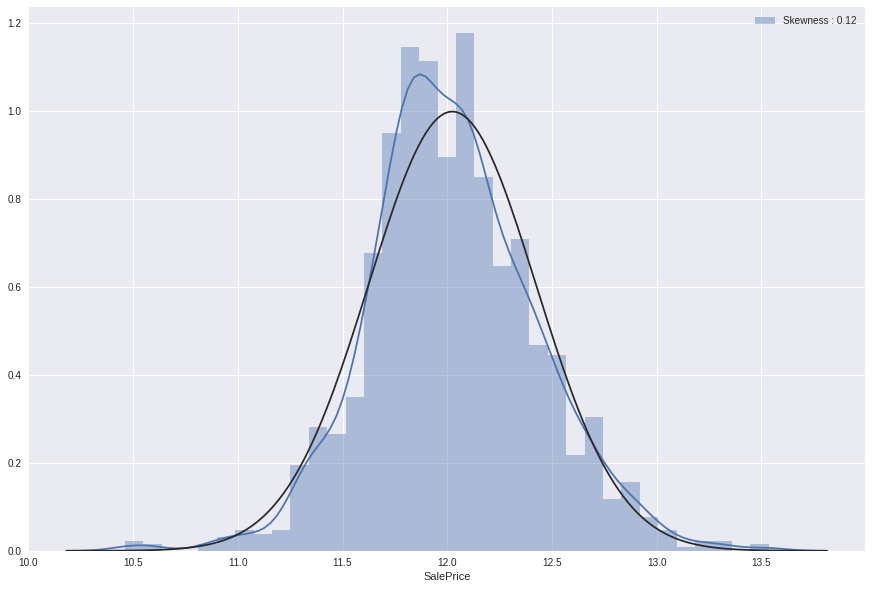

In [26]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train["SalePrice"]

#Check the new distribution 
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=stats.norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

#### Numerical Features

In [27]:
# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: stats.skew(x.astype('float'))).sort_values(ascending=False)
print skewed_feats

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.505704
1stFlrSF          1.469604
BsmtFinSF1        1.425230
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
BedroomAbvGr      0.326324
GarageArea        0.239257
OverallQual       0.197110
FullBath          0.167606
GarageCars       -0.219581
YearRemodAdd     -0.451020
YearBuilt        -0.599806
GarageYrBlt      -3.906205
dtype: float64


Select only the features with skewness larger than 0.75.

In [28]:
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
print skewed_feats

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.505704
1stFlrSF          1.469604
BsmtFinSF1        1.425230
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
GarageYrBlt      -3.906205
dtype: float64


Let's plot some of the skewed features.

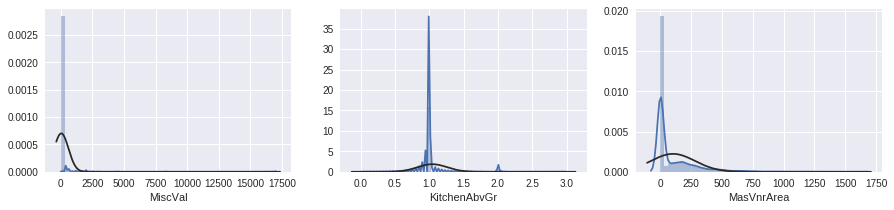

In [29]:
plt.subplots(figsize =(15, 3))
plt.subplot(1, 3, 1)
g = sns.distplot(all_data[skewed_feats.index[0]], fit=stats.norm)
plt.subplot(1, 3, 2)
g = sns.distplot(all_data[skewed_feats.index[5]], fit=stats.norm)
plt.subplot(1, 3, 3)
g = sns.distplot(all_data[skewed_feats.index[10]], fit=stats.norm)

We can reduce skewness by using **logarithm transform**.

In [0]:
for col in skewed_feats.index:
  all_data[col] = np.log1p(all_data[col])

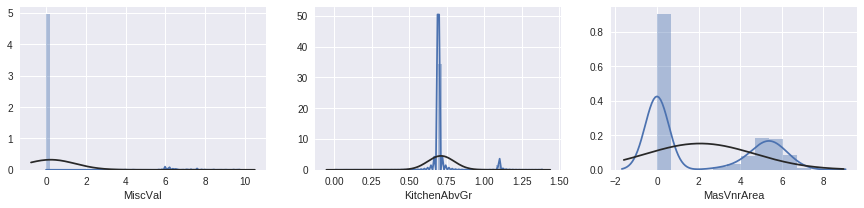

In [31]:
plt.subplots(figsize =(15, 3))
plt.subplot(1, 3, 1)
g = sns.distplot(all_data[skewed_feats.index[0]], fit=stats.norm)
plt.subplot(1, 3, 2)
g = sns.distplot(all_data[skewed_feats.index[5]], fit=stats.norm)
plt.subplot(1, 3, 3)
g = sns.distplot(all_data[skewed_feats.index[10]], fit=stats.norm)

## Modeling

Let's import some packages that will be used to define and train our models

In [0]:
# importing packages
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV

### Preparation of data

In [33]:
# First, re-create the training and test datasets
train = all_data[:num_train]
test = all_data[num_train:]

print(train.shape)
print(test.shape)

(1460, 330)
(1459, 330)


It is important to partition the train dataset in validation and train before testing with the real test data

In [34]:
# Next we want to sample our training data to test for performance of robustness ans accuracy, before applying to the test data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(train, y_train, test_size=0.3, random_state=0)

print('X_train: ', X_train.shape, 'X_test: ', X_test.shape, 'Y_train: ', Y_train.shape, 'Y_test: ', Y_test.shape)

('X_train: ', (1022, 330), 'X_test: ', (438, 330), 'Y_train: ', (1022,), 'Y_test: ', (438,))


### Validation Function and Coefficients

We will use two methods:
* **validate_model:** This method will validate our model according to the training data using cross validation.
* **coef**: This method will print the values of the most important features after training our models.

In [0]:
def validate_model(X_train, Y_train, model, num_folds=5, random_state=0, verbose=True):
  
  # fit training data
  model.fit(X_train, Y_train)
  # define number of folds
  kf = KFold(num_folds, shuffle=True, random_state=random_state).get_n_splits(X_train.values)
  # use of cross-validation in our dataset
  cv_results = cross_validate(model, X_train, Y_train, cv = kf, 
                              scoring= 'neg_mean_squared_error', return_train_score=True)
  
  # calculate Rooted Mean Square Error (RMSE)
  training_results = np.sqrt((-cv_results['train_score']).mean())
  val_results = np.sqrt((-cv_results['test_score']).mean())
  
  if verbose == True:
    print('Training RMSE: %.4lf,  Validation RMSE: %.4lf' % (training_results, val_results))
  return training_results, val_results


def coef(model, X, top=5):
  # iterate over the model coefficients and print the top most important features
  for l, r in sorted(zip(X.columns, model.coef_), key=lambda x: abs(x[1]), reverse=True)[:top]:
    print("(%s, %.5f)" % (l, r))

### Linear Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [36]:
model = LinearRegression()
_ = validate_model(X_train, Y_train, model)

Training RMSE: 0.0784,  Validation RMSE: 0.1677


### Ridge Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [37]:
model = Ridge(alpha=1)
_ = validate_model(X_train, Y_train, model)

Training RMSE: 0.0838,  Validation RMSE: 0.1279


Try different parameters

In [38]:
alpha = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
best_parameter = alpha[0]
best_rmse = 100
for i in alpha:
  print("Regularization parameter: %.2lf" % i)
  model = Ridge(alpha=i)
  training_result, val_result = validate_model(X_train, Y_train, model)
  if best_rmse > val_result:
    best_rmse = val_result
    best_parameter = i
print("Best parameter: %lf" % best_parameter)

Regularization parameter: 0.00
Training RMSE: 0.0785,  Validation RMSE: 0.1477
Regularization parameter: 0.01
Training RMSE: 0.0786,  Validation RMSE: 0.1403
Regularization parameter: 0.10
Training RMSE: 0.0789,  Validation RMSE: 0.1353
Regularization parameter: 1.00
Training RMSE: 0.0838,  Validation RMSE: 0.1279
Regularization parameter: 10.00
Training RMSE: 0.0978,  Validation RMSE: 0.1257
Regularization parameter: 100.00
Training RMSE: 0.1228,  Validation RMSE: 0.1375
Best parameter: 10.000000


In [39]:
# model with best parameters
model = Ridge(alpha=10)
_ = validate_model(X_train, Y_train, model)

Training RMSE: 0.0978,  Validation RMSE: 0.1257


Let's review the best paremeters after training.

In [40]:
coef(model, X_train, 20)

(GrLivArea, 0.17165)
(1stFlrSF, 0.14232)
(MSZoning_C (all), -0.12815)
(Condition2_PosN, -0.09011)
(Neighborhood_Crawfor, 0.08668)
(Neighborhood_IDOTRR, -0.07724)
(Neighborhood_StoneBr, 0.06622)
(LotArea, 0.06616)
(Neighborhood_NoRidge, 0.06332)
(Neighborhood_Edwards, -0.06237)
(Condition2_Norm, 0.06056)
(Functional_Typ, 0.05644)
(OverallQual, 0.05486)
(Condition1_Norm, 0.05283)
(MSZoning_FV, 0.05176)
(Exterior1st_BrkFace, 0.05070)
(Neighborhood_Mitchel, -0.04918)
(SaleCondition_Abnorml, -0.04883)
(SaleType_ConLD, 0.04782)
(KitchenQual_Ex, 0.04575)


### Lasso Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [41]:
model = Lasso(alpha=0.01)
_ = validate_model(X_train, Y_train, model)

Training RMSE: 0.1437,  Validation RMSE: 0.1479


In [42]:
alpha = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
best_parameter = alpha[0]
best_rmse = 100
for i in alpha:
  print("Regularization parameter: %.2lf" % i)
  model = Lasso(alpha=i)
  training_result, val_result = validate_model(X_train, Y_train, model)
  if best_rmse > val_result:
    best_rmse = val_result
    best_parameter = i

print("Best parameter: %lf" % best_parameter)

Regularization parameter: 0.00
Training RMSE: 0.1052,  Validation RMSE: 0.1222
Regularization parameter: 0.01
Training RMSE: 0.1437,  Validation RMSE: 0.1479
Regularization parameter: 0.10
Training RMSE: 0.2227,  Validation RMSE: 0.2264
Regularization parameter: 1.00
Training RMSE: 0.2670,  Validation RMSE: 0.2685
Regularization parameter: 10.00
Training RMSE: 0.3035,  Validation RMSE: 0.3043
Regularization parameter: 100.00
Training RMSE: 0.4018,  Validation RMSE: 0.4027
Best parameter: 0.001000


In [43]:
model = Lasso(alpha=0.001)
_ = validate_model(X_train, Y_train, model)

Training RMSE: 0.1052,  Validation RMSE: 0.1222


Let's review the best paremeters after training.

In [44]:
coef(model, X_train, 20)

(GrLivArea, 0.34318)
(MSZoning_C (all), -0.21348)
(Condition2_PosN, -0.13452)
(1stFlrSF, 0.09740)
(Neighborhood_Crawfor, 0.09596)
(LotArea, 0.07187)
(Functional_Typ, 0.06888)
(OverallQual, 0.06204)
(SaleCondition_Abnorml, -0.05641)
(KitchenQual_Ex, 0.05632)
(Neighborhood_NoRidge, 0.05357)
(Condition1_Norm, 0.05357)
(BsmtQual_Ex, 0.05048)
(OverallCond, 0.04143)
(Neighborhood_BrkSide, 0.04010)
(Exterior1st_BrkFace, 0.03920)
(Neighborhood_StoneBr, 0.03678)
(Neighborhood_IDOTRR, -0.03676)
(CentralAir_N, -0.03633)
(Neighborhood_NridgHt, 0.03508)


#### Feature Selection

Use best features obtained with Lasso, to do that we use only the features with parameters different than 0

In [0]:
def feat_selection(model, X, top=5):
  feat = []
  for l, r in sorted(zip(X.columns, model.coef_), key=lambda x: abs(x[1]), reverse=True)[:top]:
    if r > 0:
      feat.append(l)
  return feat

In [0]:
lasso_feat = feat_selection(model, X_train, 20)

X_train_small = X_train[lasso_feat]
X_test_small = X_test[lasso_feat]

In [47]:
model = Lasso(alpha=0.001)
_ = validate_model(X_train_small, Y_train, model)

Training RMSE: 0.1668,  Validation RMSE: 0.1701


### Grid Search

Set different values for all possible parameters

In [0]:
lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 
                    'copy_X': [True], 'fit_intercept': [True], 
                    'normalize': [False, True], 'precompute': [False], 
                    'max_iter': [300, 400, 500, 800], 'tol': [0.01], 
                    'selection': ['random'], 'random_state': [None]}

Specify the model and grid search

In [0]:
model = Lasso(alpha=0.001)
grid_search = GridSearchCV(model, param_grid = lasso_param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

Perform Grid Search using training data

In [50]:
grid_search.fit(X_train, Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'normalize': [False, True], 'precompute': [False], 'selection': ['random'], 'tol': [0.01], 'fit_intercept': [True], 'copy_X': [True], 'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'max_iter': [300, 400, 500, 800], 'random_state': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Get best parameters obtained with grid search

In [51]:
best_params = grid_search.best_estimator_
print best_params

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=400,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.01, warm_start=False)
